Some references:


*   https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
*   https://pythonnumericalmethods.berkeley.edu/notebooks/chapter22.03-The-Euler-Method.html

Flops:

*   https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-841975359
*   https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-849439287

Custom RNN:

*   https://www.tensorflow.org/guide/keras/working_with_rnns


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 402
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.95
t_final = 0.01
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

In [4]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 2, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 2, endpoint=True)
T_initial = np.linspace(300, 600, 80, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 80, endpoint=True) - C_As

In [5]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 500
shape of x_deviation is (500, 2)


In [6]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [7]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [8]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

CA0_input_neg = CA0_input

(2000,)
(2000, 20)


In [9]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

# RNN_input = np.concatenate((CA0_input, Q_input, CA_input, T_input), axis=2)
RNN_input = np.concatenate((CA0_input, Q_input, CA_input, T_input, CA0_input_neg, Q_input_neg, CA_input_neg, T_input_neg), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""
RNN_input = RNN_input.repeat(20, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (2000, 20, 8)


In [10]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-3.50000000e+00 -5.00000000e+05  1.46772152e+00 -7.54177215e+01
  3.50000000e+00  5.00000000e+05 -1.46772152e+00  7.54177215e+01]
[-3.50000000e+00 -5.00000000e+05  1.46772152e+00 -7.54177215e+01
  3.50000000e+00  5.00000000e+05 -1.46772152e+00  7.54177215e+01]


In [12]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, 20, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, 20, 1)

RNN_output = np.concatenate((CA_output, T_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (2000, 20, 2)


In [13]:
# checking output
print(RNN_output[0, :5])

[[  1.46616326 -75.64251434]
 [  1.45840342 -76.76577877]
 [  1.45069444 -77.88780535]
 [  1.44303427 -79.00850088]
 [  1.43542096 -80.12777779]]


In [14]:
num_dims = 8

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))


X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,20,num_dims)
X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,20,num_dims)
y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,20,2)

In [15]:
# set the seed for reproducibility
tf.random.set_seed(42)

# build the model
# model = Sequential()
# skip RNN
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = SimpleRNN(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
# x = Dense(4, activation='tanh', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x_skip = x
# x = SimpleRNN(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Dense(4, activation='tanh', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

# real input convex RNN
# MSE 3.2861e-04
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = SimpleRNN(64, activation='relu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = SimpleRNN(64, activation='relu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

# plain RNN
# model.add(SimpleRNN(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg()))
# model.add(SimpleRNN(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg()))
# model.add(Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))

# plain LSTM
# model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(Dense(2, activation='linear'))

# plain GRU
# model.add(GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg()))
# model.add(GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg()))
# model.add(Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))

# input convex LSTM
input = Input(shape=(X_train.shape[1],X_train.shape[2]))
x_skip = input
x = SimpleRNN(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Add()([x, x_skip])
x = SimpleRNN(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Add()([x, x_skip])
x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

# input convex GRU
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
# x = Dense(4, activation='tanh', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Dense(4, activation='tanh', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/1000
5/5 - 3s - loss: 2.6815 - mean_squared_error: 2.6815 - val_loss: 1.3643 - val_mean_squared_error: 1.3643 - 3s/epoch - 678ms/step
Epoch 2/1000
5/5 - 0s - loss: 1.2009 - mean_squared_error: 1.2009 - val_loss: 1.1629 - val_mean_squared_error: 1.1629 - 148ms/epoch - 30ms/step
Epoch 3/1000
5/5 - 0s - loss: 1.0216 - mean_squared_error: 1.0216 - val_loss: 0.9945 - val_mean_squared_error: 0.9945 - 148ms/epoch - 30ms/step
Epoch 4/1000
5/5 - 0s - loss: 0.9000 - mean_squared_error: 0.9000 - val_loss: 0.9358 - val_mean_squared_error: 0.9358 - 147ms/epoch - 29ms/step
Epoch 5/1000
5/5 - 0s - loss: 0.8357 - mean_squared_error: 0.8357 - val_loss: 0.8593 - val_mean_squared_error: 0.8593 - 167ms/epoch - 33ms/step
Epoch 6/1000
5/5 - 0s - loss: 0.7693 - mean_squared_error: 0.7694 - val_loss: 0.8119 - val_mean_squared_error: 0.8119 - 158ms/epoch - 32ms/step
Epoch 7/1000
5/5 - 0s - loss: 0.7258 - mean_squared_error: 0.7258 - val_loss: 0.7659 - val_mean_squared_error: 0.7659 - 168ms/epoch - 34ms

In [16]:
# RNN model
# model.save('/content/drive/MyDrive/MPC/model.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model.h5')

# LSTM model
# model.save('/content/drive/MyDrive/MPC/model1.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model1.h5')

# skip_RNN model
# model.save('/content/drive/MyDrive/MPC/model2.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model2.h5')

# input_convex_RNN model
# model.save('/content/drive/MyDrive/MPC/model3.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model3.h5')

# input_convex_LSTM model
# model.save('/content/drive/MyDrive/MPC/model4.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model4.h5')

# input_convex_1layer_LSTM model
# model.save('/content/drive/MyDrive/MPC/model5.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model5.h5')

# 1layer_LSTM model
# model.save('/content/drive/MyDrive/MPC/model6.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model6.h5')

# input_convex_GRU model
# model.save('/content/drive/MyDrive/MPC/model7.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model7.h5')

# GRU model
# model.save('/content/drive/MyDrive/MPC/model8.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model8.h5')

# input_convex_resRNN model
# MSE loss 9.6485e-05
model.save('/content/drive/MyDrive/MPC/model9.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model9.h5')

In [17]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


The FLOPs is:60520


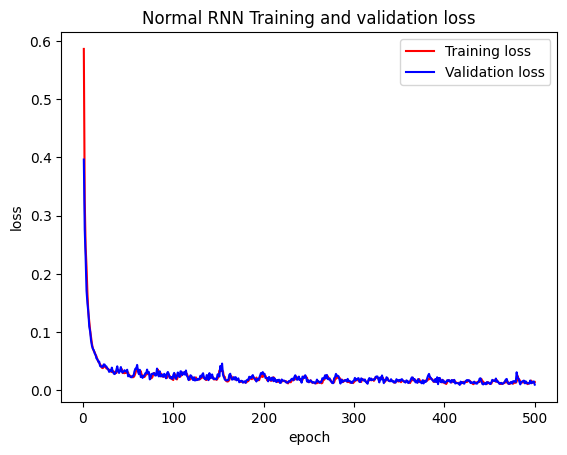

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

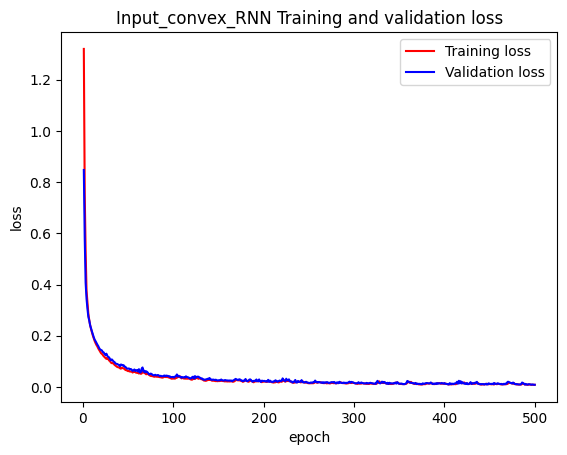

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Input_convex_RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

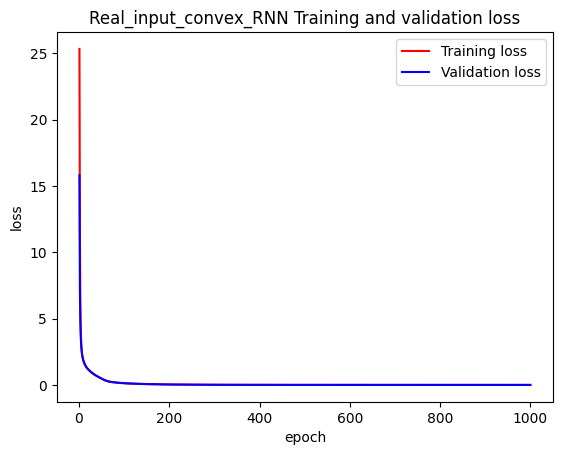

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Real_input_convex_RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

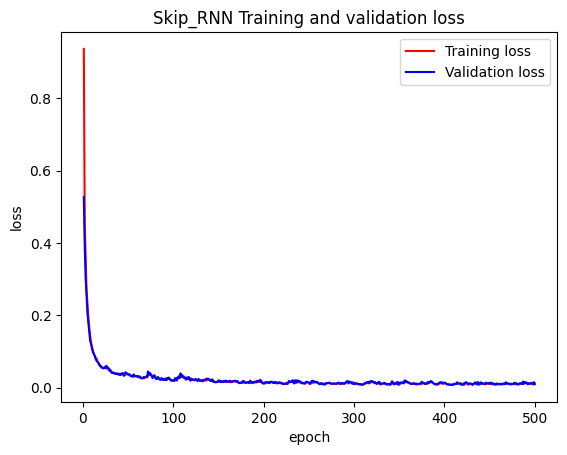

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Skip_RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

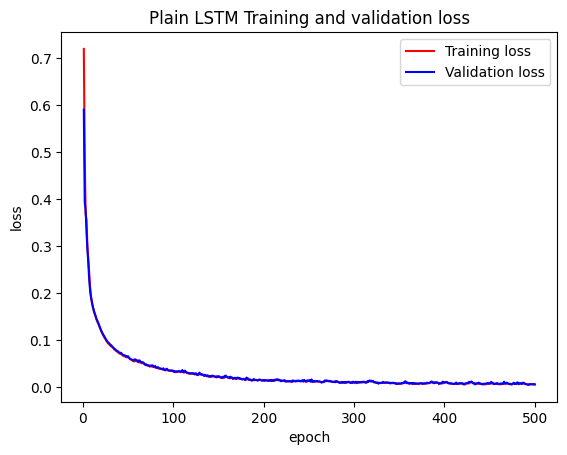

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Plain LSTM Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

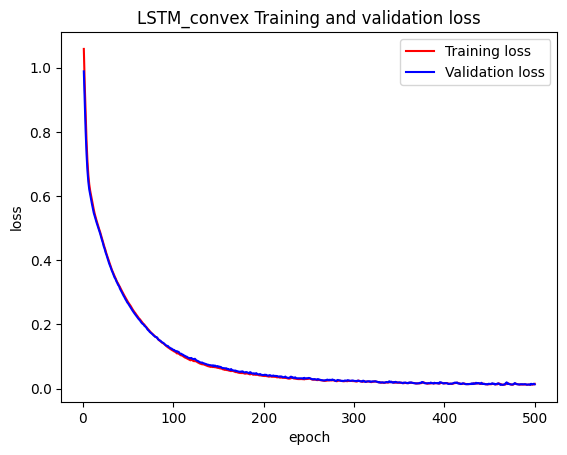

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM_convex Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

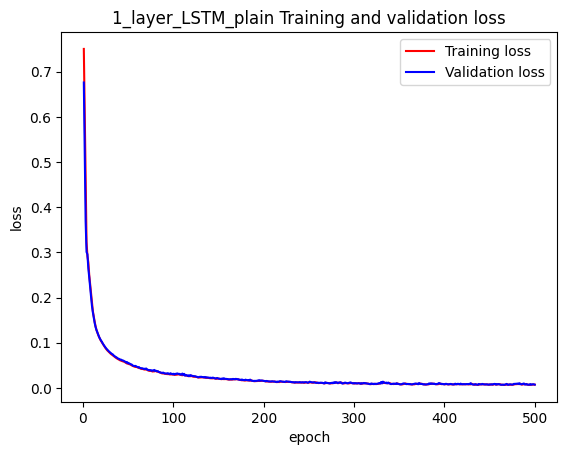

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1_layer_LSTM_plain Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

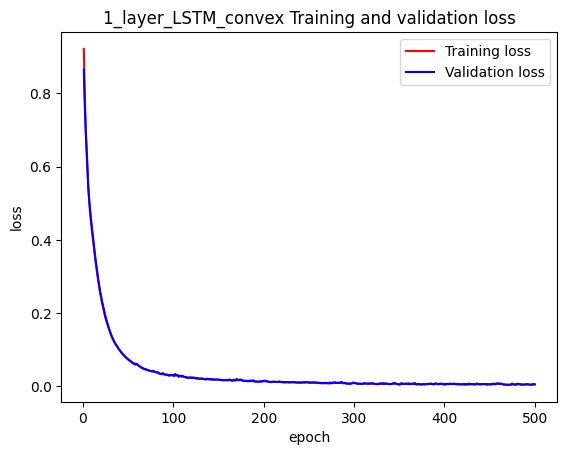

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1_layer_LSTM_convex Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

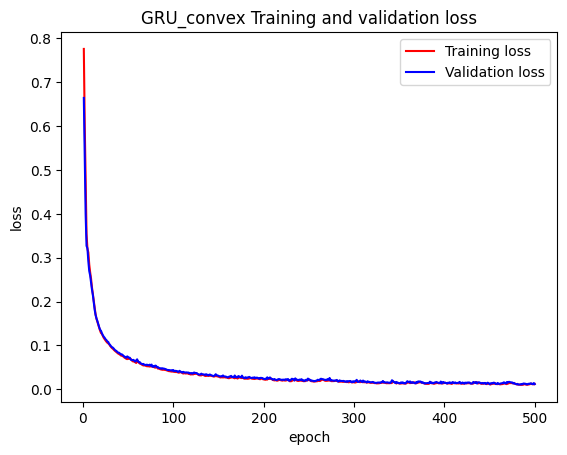

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU_convex Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

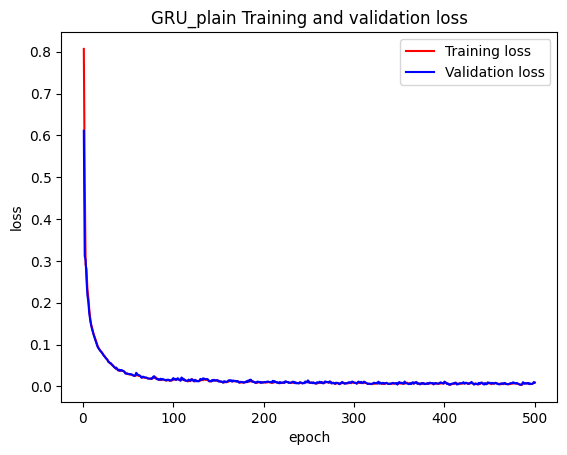

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU_plain Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

<ipython-input-97-aeb71372356d>:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


19/19 [==============================] - 1s 8ms/step
(600, 20, 2)


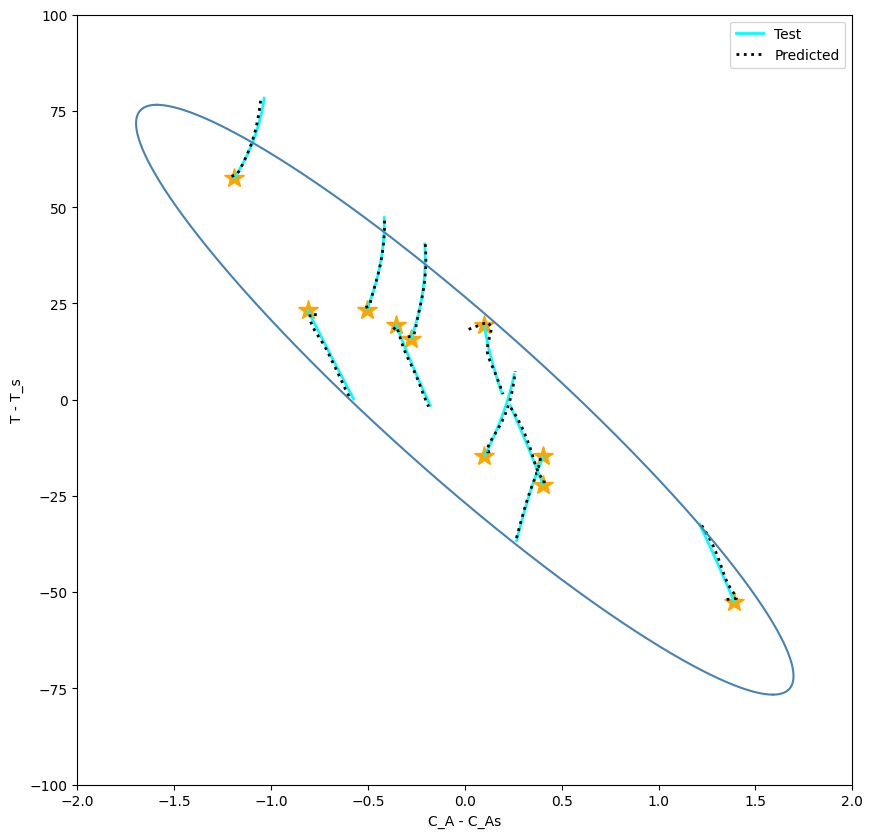

In [97]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

# plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,20,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,20,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(-X_plot[i, 0, -2], -X_plot[i, 0, -1], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(-X_plot[i, 0, -2], -X_plot[i, 0, -1], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':')


# plot stability region
plt.plot(x_lower, y_plot, color='steelblue')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()


In [ ]:
print(y_predict[8, :, 0])
print(y_test[8, :, 0])
print(X_plot[8, 0, -2])

[1.3602319 1.4005332 1.3757235 1.3606988 1.3521417 1.3425821 1.3319049
 1.3213924 1.3116863 1.3027669 1.2942876 1.2858219 1.2770008 1.267576
 1.257445  1.2466431 1.2353132 1.2236633 1.2119255 1.2003202]
[1.39003544 1.3813208  1.37255227 1.36372698 1.35484194 1.34589406
 1.33688014 1.3277969  1.31864091 1.30940864 1.30009643 1.29070049
 1.2812169  1.27164162 1.26197043 1.252199   1.24232283 1.23233723
 1.2222374  1.21201832]
1.3917721518987343


In [ ]:
# compute deltaCA and deltaT for each time step
y_predict = model.predict(RNN_input)
print(y_predict.shape)

def euler(X, X_next):
  return (X_next - X)/t_step

CA_gradient = list()
T_gradient = list()

for i in range(y_predict.shape[0]):
  for j in range(y_predict.shape[1]-1):
    CA_gradient.append(euler(y_predict[i, j, 0], y_predict[i, j+1, 0]))
    T_gradient.append(euler(y_predict[i, j, 1], y_predict[i, j+1, 1]))

CA_gradient = np.array(CA_gradient).reshape(2000, -1)
T_gradient = np.array(T_gradient).reshape(2000, -1)
RNN_gradient = np.dstack([CA_gradient, T_gradient])
print(RNN_gradient.shape)

63/63 [==============================] - 1s 10ms/step
(2000, 20, 2)
(2000, 19, 2)


In [ ]:
tf.random.set_seed(42)

class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        # self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        self.state_size = self.units
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        # self.D1 = self.add_weight(shape=(self.units, self.units),
        #                          initializer='uniform',
        #                          name='D1',
        #                          constraint=tf.keras.constraints.NonNeg(),
        #                          trainable=True)
        # self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
        #                          initializer='uniform',
        #                          name='D2',
        #                          constraint=tf.keras.constraints.NonNeg(),
        #                          trainable=True)
        # self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
        #                          initializer='uniform',
        #                          name='D3',
        #                          constraint=tf.keras.constraints.NonNeg(),
        #                          trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        # plain RNN
        # MSE loss 7.9252e-04
        prev_output = states[0]
        h = K.dot(inputs, self.kernel) + K.dot(prev_output, self.recurrent_kernel)
        h = tf.nn.tanh(h)
        y = K.dot(h, self.V)
        return y, [h]

        # input convex RNN
        # MSE loss 0.0028
        # prev_h, prev_input = states
        # h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        # h = tf.nn.elu(h)
        # y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        # y = tf.nn.elu(y)
        # return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

# model = tf.keras.Sequential([
#     tf.keras.layers.RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True),
#     tf.keras.layers.RNN(MyRNNCell(units=64, input_shape_custom=64),return_sequences=True),
#     tf.keras.layers.Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())
# ])

# MSE loss 3.4411e-04
input = Input(shape=(X_train.shape[1],X_train.shape[2]))
x_skip = input
x = RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(input),
x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
x = Add()([x, x_skip])
x = RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(x),
x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
x = Add()([x, x_skip])
x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/1000
5/5 - 24s - loss: 2.3511 - mean_squared_error: 2.3511 - val_loss: 1.7771 - val_mean_squared_error: 1.7771 - 24s/epoch - 5s/step
Epoch 2/1000
5/5 - 1s - loss: 1.6206 - mean_squared_error: 1.6206 - val_loss: 1.6509 - val_mean_squared_error: 1.6509 - 563ms/epoch - 113ms/step
Epoch 3/1000
5/5 - 1s - loss: 1.5248 - mean_squared_error: 1.5248 - val_loss: 1.5514 - val_mean_squared_error: 1.5514 - 670ms/epoch - 134ms/step
Epoch 4/1000
5/5 - 1s - loss: 1.4308 - mean_squared_error: 1.4308 - val_loss: 1.4420 - val_mean_squared_error: 1.4420 - 783ms/epoch - 157ms/step
Epoch 5/1000
5/5 - 1s - loss: 1.3387 - mean_squared_error: 1.3387 - val_loss: 1.3441 - val_mean_squared_error: 1.3441 - 770ms/epoch - 154ms/step
Epoch 6/1000
5/5 - 1s - loss: 1.2478 - mean_squared_error: 1.2478 - val_loss: 1.2488 - val_mean_squared_error: 1.2488 - 876ms/epoch - 175ms/step
Epoch 7/1000
5/5 - 1s - loss: 1.1665 - mean_squared_error: 1.1665 - val_loss: 1.1588 - val_mean_squared_error: 1.1588 - 957ms/epoch - 

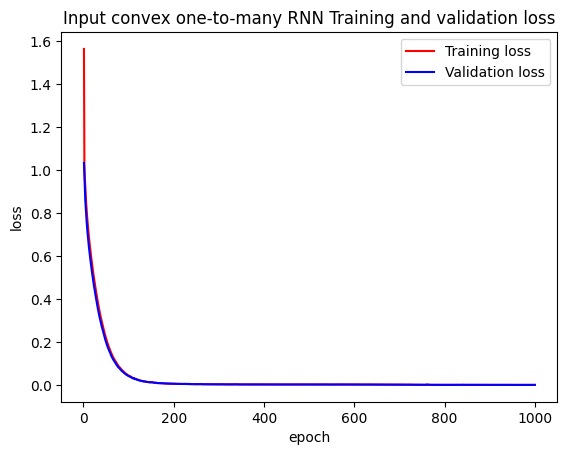

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Input convex one-to-many RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

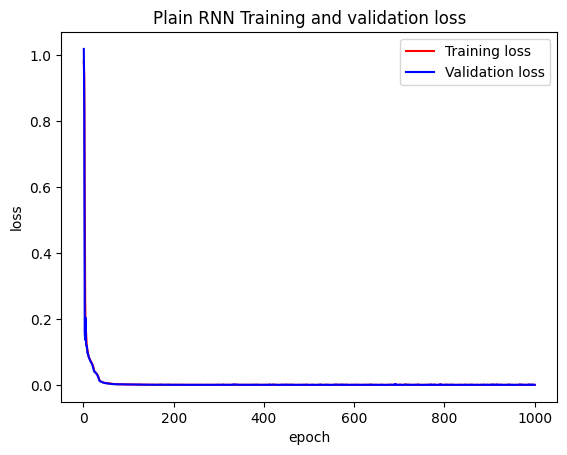

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Plain RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [113]:
# my tanh ICRNN
# MSE loss 7.9917e-04
# model.save('/content/drive/MyDrive/MPC/model10.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model10.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my relu ICRNN
# MSE loss 0.0046
# model.save('/content/drive/MyDrive/MPC/model13.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model13.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my elu ICRNN
# MSE loss 0.0028
# model.save('/content/drive/MyDrive/MPC/model14.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model14.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh plain RNN
# MSE loss 7.9252e-04
# model.save('/content/drive/MyDrive/MPC/model11.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model11.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res model with plain RNN
# MSE loss 4.0038e-04
# model.save('/content/drive/MyDrive/MPC/model3.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model3.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res ICRNN model with ICRNN
# MSE loss 4.3711e-04
# model.save('/content/drive/MyDrive/MPC/model12.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model12.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res model with plain RNN using 3 layers
# MSE loss 4.8507e-04
# model.save('/content/drive/MyDrive/MPC/model16.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model16.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh plain LSTM
# MSE loss 8.4152e-06
model.save('/content/drive/MyDrive/MPC/model17.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model17.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res model with plain LSTM
# MSE loss 1.8458e-04
# model.save('/content/drive/MyDrive/MPC/model18.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model18.h5', custom_objects={"MyRNNCell": MyRNNCell})

In [114]:
model.summary()
print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_25 (RNN)                (None, 20, 64)            17408     
                                                                 
 rnn_26 (RNN)                (None, 20, 64)            32768     
                                                                 
 dense_29 (Dense)            (None, 20, 2)             130       
                                                                 
Total params: 50,306
Trainable params: 50,306
Non-trainable params: 0
_________________________________________________________________


The FLOPs is:105896


In [112]:
class MyLSTMCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [self.units, self.units]
        super(MyLSTMCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1] + self.units, 4 * self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      trainable=True)
        self.built = True

    def call(self, inputs, states):
        h_tm1 = states[0]  # previous hidden state
        c_tm1 = states[1]  # previous cell state

        combined_inputs = tf.matmul(tf.concat([inputs, h_tm1], axis=-1), self.kernel)
        i, f, o, g = tf.split(combined_inputs, num_or_size_splits=4, axis=1)

        i = tf.nn.sigmoid(i)
        f = tf.nn.sigmoid(f)
        o = tf.nn.sigmoid(o)
        g = tf.nn.tanh(g)

        new_c = f * c_tm1 + i * g
        new_h = o * tf.nn.tanh(new_c)

        return new_h, [new_h, new_c]

    def get_config(self):
        config = super(MyLSTMCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

model = tf.keras.Sequential([
    tf.keras.layers.RNN(MyLSTMCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True),
    tf.keras.layers.RNN(MyLSTMCell(units=64, input_shape_custom=64),return_sequences=True),
    tf.keras.layers.Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())
])

# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = RNN(MyLSTMCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(input),
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
# x = Add()([x, x_skip])
# x = RNN(MyLSTMCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(x),
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/1000
5/5 - 4s - loss: 0.9792 - mean_squared_error: 0.9792 - val_loss: 1.0189 - val_mean_squared_error: 1.0189 - 4s/epoch - 821ms/step
Epoch 2/1000
5/5 - 0s - loss: 0.9540 - mean_squared_error: 0.9540 - val_loss: 0.9799 - val_mean_squared_error: 0.9799 - 488ms/epoch - 98ms/step
Epoch 3/1000
5/5 - 1s - loss: 0.9071 - mean_squared_error: 0.9071 - val_loss: 0.8968 - val_mean_squared_error: 0.8968 - 586ms/epoch - 117ms/step
Epoch 4/1000
5/5 - 0s - loss: 0.8006 - mean_squared_error: 0.8006 - val_loss: 0.7155 - val_mean_squared_error: 0.7155 - 488ms/epoch - 98ms/step
Epoch 5/1000
5/5 - 1s - loss: 0.5799 - mean_squared_error: 0.5799 - val_loss: 0.4544 - val_mean_squared_error: 0.4544 - 506ms/epoch - 101ms/step
Epoch 6/1000
5/5 - 1s - loss: 0.3898 - mean_squared_error: 0.3898 - val_loss: 0.3581 - val_mean_squared_error: 0.3581 - 681ms/epoch - 136ms/step
Epoch 7/1000
5/5 - 1s - loss: 0.3046 - mean_squared_error: 0.3046 - val_loss: 0.2684 - val_mean_squared_error: 0.2684 - 889ms/epoch - 1